# Deriving Metrics from Intercom Metadata
This notebook will lay out how to get a Customer Satisfaction metric for the conversations that are being had on Intercom. It will also show a couple different ways of grouping that data to get different insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
def report_writer(dfs:dict, report_name:str):
    """Creates an excel report using a dictionary of dfs.

    Args:
        dfs (dict): Data
        report_name (str): Name of file.
    """
    writer = pd.ExcelWriter(report_name, engine='xlsxwriter')
    workbook = writer.book
    format = workbook.add_format()
    format.set_align('center')
    for sheetname, df in dfs.items():
        df.to_excel(writer, sheet_name=sheetname, index=False)
        worksheet = writer.sheets[sheetname]
        for idx, col in enumerate(df):
            series =df[col]
            max_len = max((
                series.astype(str).map(len).max(),
                len(str(series.name))
            ))+1
            worksheet.set_column(idx, idx, max_len, format)

    writer.close()

In [2]:
data = pd.read_csv('data/metadata_231116.csv')
data['Created at'] = pd.to_datetime(data['Created at'])
rated_data = data.dropna(subset='Conversation rating')
data = data[data['Inbound/Outbound'] == 'Inbound']

[Customer Satisfaction can be calculated from a 5 point scale.](https://www.fullview.io/blog/how-to-calculate-csat#:~:text=Scores%20of%201%20to%203,responses%20and%20multiply%20by%20100.) The metric is defined as the number of 4 or 5 star reviews/total number of reviews. Once the following column is created, you can group the data by any column and get the mean of `customer_satisfaction` to get the customer satsifaction score.

In [3]:
rated_data['customer_satisfaction'] = [1 if x >= 4 else 0 for x in rated_data['Conversation rating']]

### Creating Categorical Columns to Group By

In [4]:
def categorize_response_time(x):
    if x < 60:
        return '0)0-1 min'
    elif x < 60*5:
        return '1)1-5 min'
    elif x < 60*15:
        return '2)5-15 min'
    elif x < 60*30:
        return '3)15-30 min'
    elif x < 60*60:
        return '4)30-60 min'
    elif x < 60*120:
        return '5)60-120 min'
    else:
        return '6)>120 min'
rated_data['time_to_respond_cat'] = [categorize_response_time(x) for x in rated_data['Time to first reply (seconds)']]

In [5]:
def categorize_close_time(x):
    if x < 60*60:
        return '0)<1 hour'
    elif x < 60*60*2:
        return '1)1-2 hours'
    elif x < 60*60*3:
        return '2)2-3 hours'
    elif x < 60*60*4:
        return '3)3-4 hours'
    elif x < 60*60*8:
        return '4)4-8 hours'
    elif x < 60*60*24:
        return '5)8-24 hours'
    else:
        return '6)>24 hours'
    
rated_data['time_to_close_cat'] = [categorize_close_time(x) for x in rated_data['Time to last close (seconds)']]

In [6]:
rated_data.groupby('time_to_close_cat')['Conversation ID'].nunique()

time_to_close_cat
0)<1 hour       260
1)1-2 hours     165
2)2-3 hours     138
3)3-4 hours     101
4)4-8 hours     225
5)8-24 hours    189
6)>24 hours     126
Name: Conversation ID, dtype: int64

In [7]:
rated_data['created_week'] = [x.week for x in rated_data['Created at']]
rated_data['created_month'] = [x.month for x in rated_data['Created at']]

In [8]:
rated_data['closed_by_same'] = [1 if x == y else 0 for x, y in zip(rated_data['Closed by (ID)'], rated_data['Assigned to (ID)'])]

## Creating Visualizations

In [9]:
# time to response categories
# time to close categories
# created_by week and month
# Companies (name)
# Assigned to (name)
# Closed by (name) different than Assigned to (name)

In [21]:
retdict = {
    'time_to_respond': rated_data.groupby('time_to_respond_cat').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).sort_index().reset_index().rename(columns={'Conversation ID': 'conversations_rated'}),
    'time_to_close': rated_data.groupby('time_to_close_cat').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'created_week': rated_data.groupby('created_week').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'created_month': rated_data.groupby('created_month').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'company': rated_data.groupby('Companies (name)').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'assigned_to': rated_data.groupby('Assigned to (name)').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'closed_by': rated_data.groupby('Closed by (name)').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'different_closer': rated_data.groupby('closed_by_same').agg({'Conversation ID': 'nunique', 'customer_satisfaction': 'mean'}).rename(columns={'Conversation ID': 'conversations_rated'}).sort_index().reset_index(),
    'rated_data': rated_data[['Conversation ID', 'customer_satisfaction', 'time_to_respond_cat', 'time_to_close_cat', 'created_month', 'created_week', 'Companies (name)', 'Assigned to (name)', 'Closed by (name)', 'closed_by_same']]
}

In [23]:
report_writer(retdict, 'intercom_metrics.xlsx')

In [13]:
retdict['time_to_close']

,conversations_rated,customer_satisfaction
time_to_close_cat,,
0)<1 hour,260,0.896154
1)1-2 hours,165,0.884848
2)2-3 hours,138,0.768116
3)3-4 hours,101,0.792079
4)4-8 hours,225,0.693333
5)8-24 hours,189,0.703704
6)>24 hours,126,0.706349


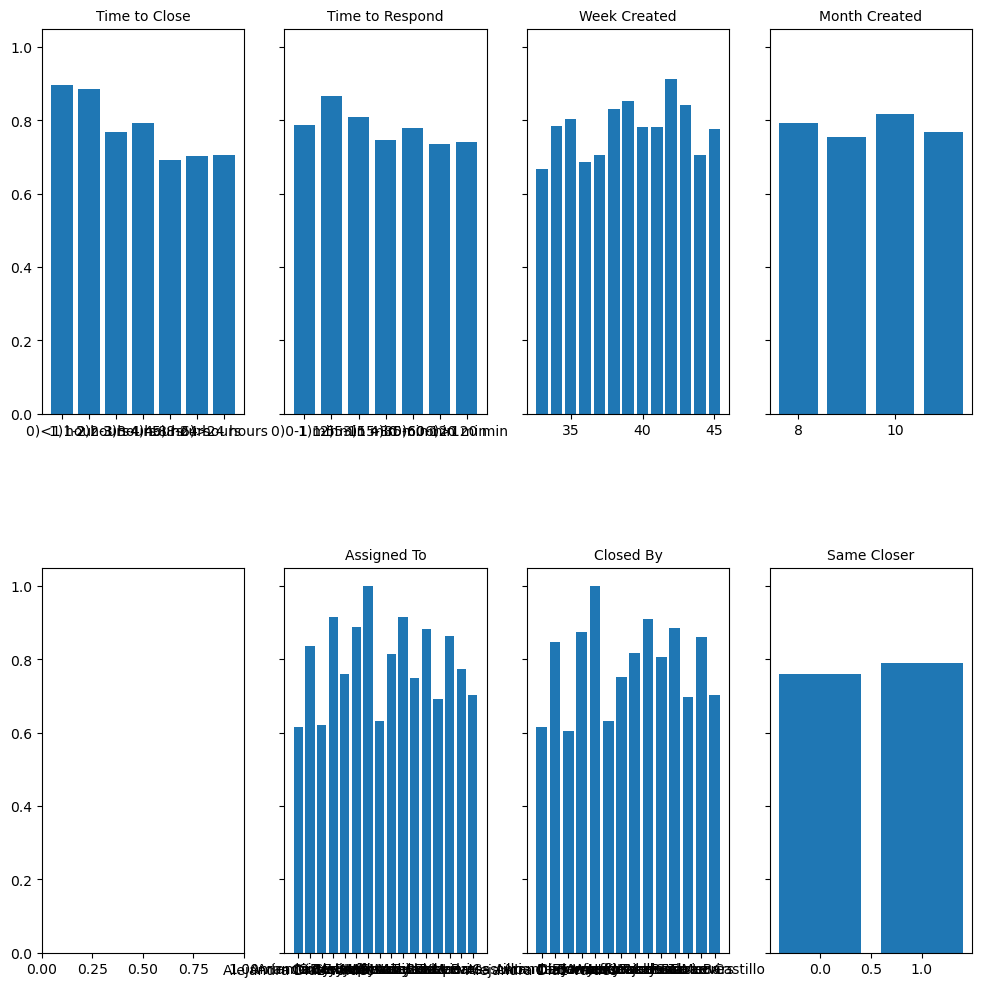

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 12), sharey=True)
fs = 10

axs[0, 0].bar(retdict['time_to_close']['time_to_close_cat'], retdict['time_to_close']['customer_satisfaction'])
axs[0, 0].set_title('Time to Close', fontsize=fs)

axs[0, 1].bar(retdict['time_to_respond']['time_to_respond_cat'], retdict['time_to_respond']['customer_satisfaction'])
axs[0, 1].set_title('Time to Respond', fontsize=fs)

axs[0, 2].bar(retdict['created_week']['created_week'], retdict['created_week']['customer_satisfaction'])
axs[0, 2].set_title('Week Created', fontsize=fs)

axs[0, 3].bar(retdict['created_month']['created_month'], retdict['created_month']['customer_satisfaction'])
axs[0, 3].set_title('Month Created', fontsize=fs)

#axs[1, 0].bar(retdict['company']['Companies (name)'], retdict['company']['customer_satisfaction'])
#axs[1, 0].set_title('Company', fontsize=fs)

axs[1, 1].bar(retdict['assigned_to']['Assigned to (name)'], retdict['assigned_to']['customer_satisfaction'])
axs[1, 1].set_title('Assigned To', fontsize=fs)

axs[1, 2].bar(retdict['closed_by']['Closed by (name)'], retdict['closed_by']['customer_satisfaction'])
axs[1, 2].set_title('Closed By', fontsize=fs)

axs[1, 3].bar(retdict['different_closer']['closed_by_same'], retdict['different_closer']['customer_satisfaction'])
axs[1, 3].set_title('Same Closer', fontsize=fs)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
ax1 = plt.subplot()